In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
transform_train = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

transform = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])
training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [5]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

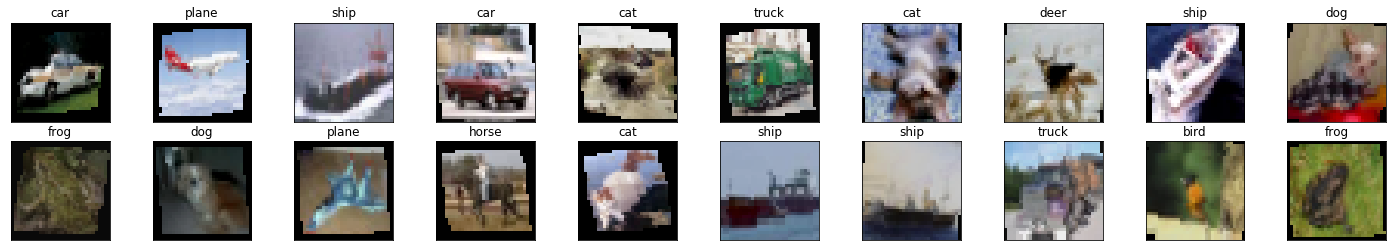

In [6]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [38]:
class C_Model(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(3, 32, 3, 1, padding=1)
      self.batch1 = nn.BatchNorm2d(32)
      self.conv2 = nn.Conv2d(32, 64, 3, 1, padding=1)
        
      self.conv3 = nn.Conv2d(64, 128, 3, 1, padding=1)
      self.batch2 = nn.BatchNorm2d(128)
      self.conv4 = nn.Conv2d(128, 128, 3, 1, padding=1)
      self.dropout1 = nn.Dropout(0.5)
        
      self.conv5 = nn.Conv2d(128, 256, 3, 1, padding=1)
      self.batch3 = nn.BatchNorm2d(256)
      self.conv6 = nn.Conv2d(256, 256, 3, 1, padding=1) 
        
      #self.conv5 = nn.Conv2d(16, 32, 3, 1, padding=1)
      #self.conv6 = nn.Conv2d(32, 64, 3, 1, padding=1)
    
      self.fc1 = nn.Linear(4*4*256, 500)
      self.dropout2 = nn.Dropout(0.5)
      self.fc2 = nn.Linear(500, 10)
    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
    
      x = F.relu(self.conv3(x))
      x = F.relu(self.conv4(x))
      x = F.max_pool2d(x, 2, 2)
      x = self.dropout2(x)

      x = F.relu(self.conv5(x))
      x = F.relu(self.conv6(x))
      x = F.max_pool2d(x, 2, 2)
    

      x = x.view(-1, 4*4*256)
      x = F.relu(self.fc1(x))
      x = self.dropout2(x)
      x = self.fc2(x)
      return x

In [39]:
model = C_Model().to(device)
model
#torch.set_default_tensor_type(torch.cuda.FloatTensor)

LeNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout1): Dropout(p=0.5)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=500, bias=True)
  (dropout2): Dropout(p=0.5)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [41]:
epochs = 50
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/ len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 1.7584, acc 33.9940 
validation loss: 1.4377, validation acc 46.3400 
epoch : 2
training loss: 1.3660, acc 49.9100 
validation loss: 1.2036, validation acc 56.5700 
epoch : 3
training loss: 1.2002, acc 56.6080 
validation loss: 1.0900, validation acc 60.7700 
epoch : 4
training loss: 1.0957, acc 60.7540 
validation loss: 0.9707, validation acc 65.9800 
epoch : 5
training loss: 1.0100, acc 64.1240 
validation loss: 0.8925, validation acc 68.5900 
epoch : 6
training loss: 0.9605, acc 66.3120 
validation loss: 0.8814, validation acc 69.4100 
epoch : 7
training loss: 0.9092, acc 68.2060 
validation loss: 0.8148, validation acc 72.3100 
epoch : 8
training loss: 0.8771, acc 69.3020 
validation loss: 0.7619, validation acc 73.8800 
epoch : 9
training loss: 0.8496, acc 70.3760 
validation loss: 0.7701, validation acc 73.1400 
epoch : 10
training loss: 0.8254, acc 71.1280 
validation loss: 0.7425, validation acc 74.7700 
epoch : 11
training loss: 0.7985, acc 72.1820 
va

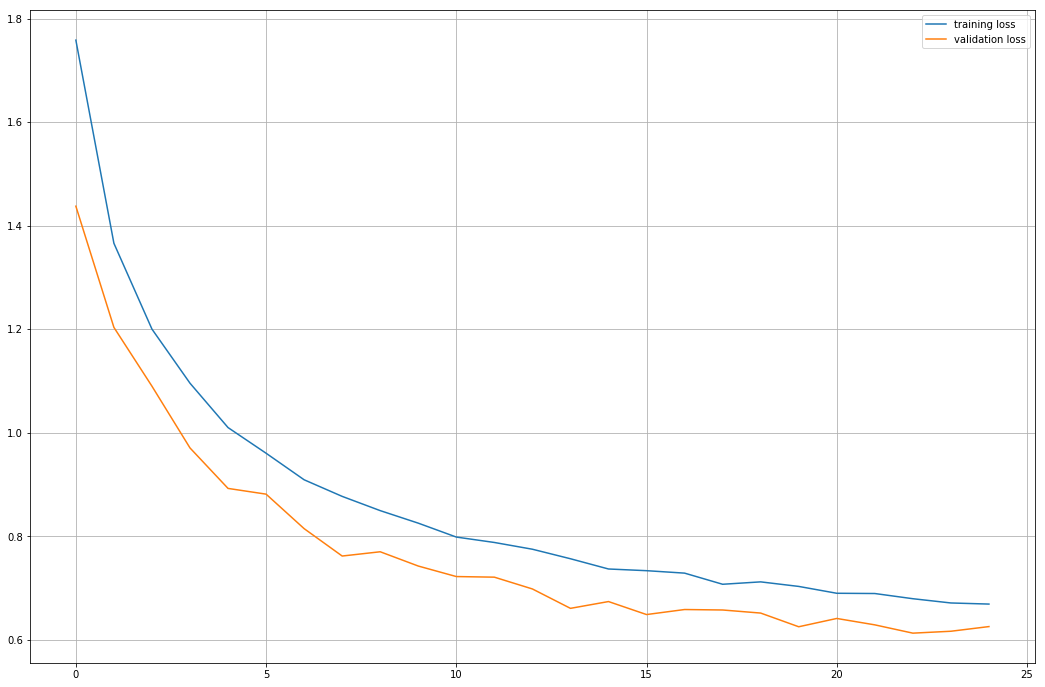

In [43]:
plt.figure(figsize=(18,12))
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.grid()
plt.legend();

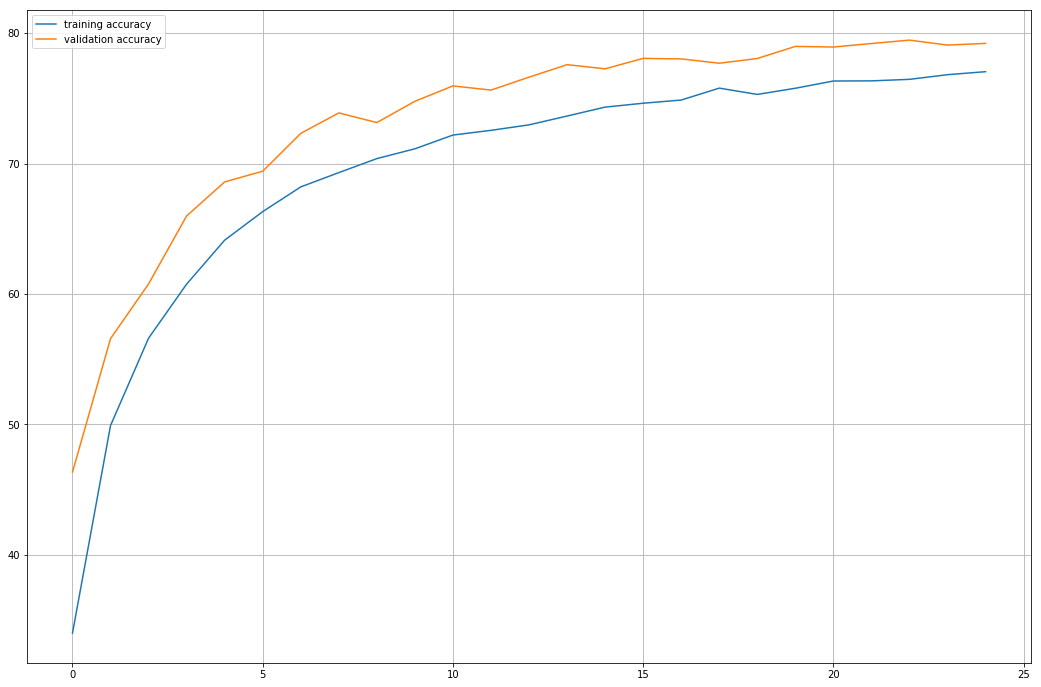

In [44]:
plt.figure(figsize=(18,12))
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.grid()
plt.legend();

In [45]:
import PIL.ImageOps

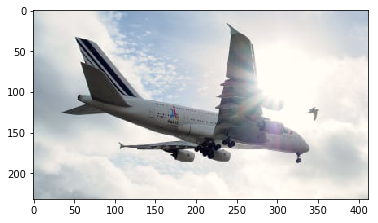

In [53]:
import requests
from PIL import Image
url1 = 'https://dynaimage.cdn.cnn.com/cnn/q_auto,w_412,c_fill,g_auto,h_232,ar_16:9/http%3A%2F%2Fcdn.cnn.com%2Fcnnnext%2Fdam%2Fassets%2F171130154604-10-things-before-plane-takes-off-cover.jpg'
response1 = requests.get(url1, stream = True)
img1 = Image.open(response1.raw)
plt.imshow(img1);
img1 = transform(img1) 
plt.imshow(im_convert(img1));
image1 = img1.to(device).unsqueeze(0)
output1 = model(image1)
_, pred1 = torch.max(output, 1)
display(classes[pred1.item()])

url2 = 'https://dynaimage.cdn.cnn.com/cnn/q_auto,w_412,c_fill,g_auto,h_232,ar_16:9/http%3A%2F%2Fcdn.cnn.com%2Fcnnnext%2Fdam%2Fassets%2F171130154604-10-things-before-plane-takes-off-cover.jpg'
response2 = requests.get(url2, stream = True)
img2 = Image.open(response2.raw)
plt.imshow(img2);

url3 = 'https://dynaimage.cdn.cnn.com/cnn/q_auto,w_412,c_fill,g_auto,h_232,ar_16:9/http%3A%2F%2Fcdn.cnn.com%2Fcnnnext%2Fdam%2Fassets%2F171130154604-10-things-before-plane-takes-off-cover.jpg'
response3 = requests.get(url3, stream = True)
img3 = Image.open(response3.raw)
plt.imshow(img3);

url4 = 'https://dynaimage.cdn.cnn.com/cnn/q_auto,w_412,c_fill,g_auto,h_232,ar_16:9/http%3A%2F%2Fcdn.cnn.com%2Fcnnnext%2Fdam%2Fassets%2F171130154604-10-things-before-plane-takes-off-cover.jpg'
response4 = requests.get(url4, stream = True)
img4 = Image.open(response4.raw)
plt.imshow(img4);

url5 = 'https://dynaimage.cdn.cnn.com/cnn/q_auto,w_412,c_fill,g_auto,h_232,ar_16:9/http%3A%2F%2Fcdn.cnn.com%2Fcnnnext%2Fdam%2Fassets%2F171130154604-10-things-before-plane-takes-off-cover.jpg'
response5 = requests.get(url5, stream = True)
img5 = Image.open(response5.raw)
plt.imshow(img5);

url6 = 'https://dynaimage.cdn.cnn.com/cnn/q_auto,w_412,c_fill,g_auto,h_232,ar_16:9/http%3A%2F%2Fcdn.cnn.com%2Fcnnnext%2Fdam%2Fassets%2F171130154604-10-things-before-plane-takes-off-cover.jpg'
response1 = requests.get(url6, stream = True)
img6 = Image.open(response6.raw)
plt.imshow(img6);

url7 = 'https://dynaimage.cdn.cnn.com/cnn/q_auto,w_412,c_fill,g_auto,h_232,ar_16:9/http%3A%2F%2Fcdn.cnn.com%2Fcnnnext%2Fdam%2Fassets%2F171130154604-10-things-before-plane-takes-off-cover.jpg'
response7 = requests.get(url7, stream = True)
img7 = Image.open(response7.raw)
plt.imshow(img7);

url8 = 'https://dynaimage.cdn.cnn.com/cnn/q_auto,w_412,c_fill,g_auto,h_232,ar_16:9/http%3A%2F%2Fcdn.cnn.com%2Fcnnnext%2Fdam%2Fassets%2F171130154604-10-things-before-plane-takes-off-cover.jpg'
response8 = requests.get(url8, stream = True)
img8 = Image.open(response8.raw)
plt.imshow(img8);

url9 = 'https://dynaimage.cdn.cnn.com/cnn/q_auto,w_412,c_fill,g_auto,h_232,ar_16:9/http%3A%2F%2Fcdn.cnn.com%2Fcnnnext%2Fdam%2Fassets%2F171130154604-10-things-before-plane-takes-off-cover.jpg'
response9 = requests.get(url9, stream = True)
img9 = Image.open(response9.raw)
plt.imshow(img9);

url10 = 'https://dynaimage.cdn.cnn.com/cnn/q_auto,w_412,c_fill,g_auto,h_232,ar_16:9/http%3A%2F%2Fcdn.cnn.com%2Fcnnnext%2Fdam%2Fassets%2F171130154604-10-things-before-plane-takes-off-cover.jpg'
response10 = requests.get(url10, stream = True)
img10 = Image.open(response10.raw)
plt.imshow(img10);


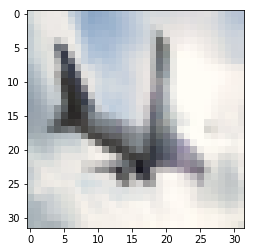

In [54]:
img1 = transform(img1) 
plt.imshow(im_convert(img1));

img2 = transform(img2) 
plt.imshow(im_convert(img2));

img3 = transform(img3) 
plt.imshow(im_convert(img3));

img4 = transform(img4) 
plt.imshow(im_convert(img4));

img5 = transform(img5) 
plt.imshow(im_convert(img5));

img6 = transform(img6) 
plt.imshow(im_convert(img6));

img7 = transform(img7) 
plt.imshow(im_convert(img7));

img8 = transform(img8) 
plt.imshow(im_convert(img8));

img9 = transform(img9) 
plt.imshow(im_convert(img9));

img10 = transform(img10) 
plt.imshow(im_convert(img10));

In [55]:
image1 = img1.to(device).unsqueeze(0)
output1 = model(image1)
_, pred1 = torch.max(output, 1)
display(classes[pred1.item()])

image2 = img2.to(device).unsqueeze(0)
output1 = model(image2)
_, pred2 = torch.max(output, 1)
display(classes[pred2.item()])

image3 = img3.to(device).unsqueeze(0)
output3 = model(image3)
_, pred3 = torch.max(output, 1)
display(classes[pred3.item()])

image3 = img3.to(device).unsqueeze(0)
output3 = model(image3)
_, pred3 = torch.max(output, 1)
display(classes[pred3.item()])

image4 = img4.to(device).unsqueeze(0)
output4 = model(image4)
_, pred4 = torch.max(output, 1)
display(classes[pred4.item()])

image5 = img5.to(device).unsqueeze(0)
output5 = model(image5)
_, pred5 = torch.max(output, 1)
display(classes[pred5.item()])

image6 = img6.to(device).unsqueeze(0)
output6 = model(image6)
_, pred6 = torch.max(output, 1)
display(classes[pred6.item()])

image7 = img7.to(device).unsqueeze(0)
output7 = model(image7)
_, pred7 = torch.max(output, 1)
display(classes[pred7.item()])

image8 = img8.to(device).unsqueeze(0)
output8 = model(image8)
_, pred1 = torch.max(output, 1)
display(classes[pred8.item()])

image9 = img9.to(device).unsqueeze(0)
output9 = model(image9)
_, pred9 = torch.max(output, 1)
display(classes[pred9.item()])

image10 = img10.to(device).unsqueeze(0)
output10 = model(image10)
_, pred10 = torch.max(output, 1)
display(classes[pred10.item()])

plane


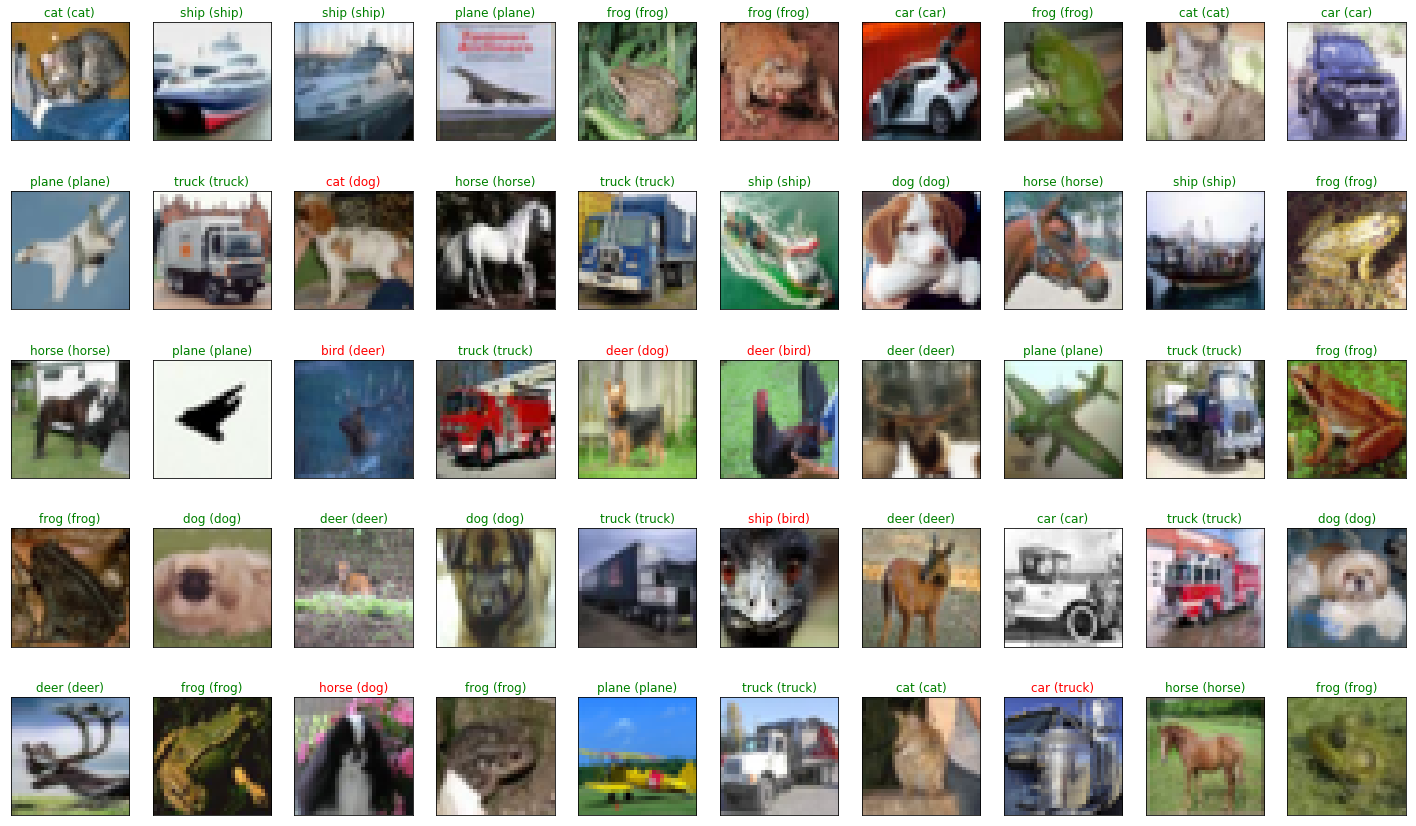

In [52]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 15))

for idx in np.arange(50):
  ax = fig.add_subplot(5, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))